In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/face_images.zip"

Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.127.40.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.40.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.127.40.122:8470']


In [3]:
IMG_SIZE = (128, 128)
IMG_PATH = "/content/face_images"
BATCH_SIZE = 32

Reading Dataset

In [4]:
def read_image(file_path: str):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    return img

def read_dataset():
    images, labels = [], []
    for file_path in tqdm(glob(IMG_PATH + "/*/*.jpg")):
        images.append(read_image(file_path))
        if "female" in file_path:
            labels.append(0)
        else:
            labels.append(1)

    return np.array(images), np.array(labels)

In [5]:
# Reading dataset and splitting into train set and validation set
images, labels = read_dataset()

trainImages, validImages, trainLabels, validLabels = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=21)

train_ds = (trainImages, trainLabels)
valid_ds = (validImages, validLabels)

print("Train Size: ", len(train_ds[0]))
print("Valid Size: ", len(valid_ds[0]))

del trainImages, validImages, trainLabels, validLabels

100%|██████████| 22801/22801 [00:56<00:00, 403.46it/s]


Train Size:  18240
Valid Size:  4561


In [6]:
classes = ['female', 'male']
print(classes)

['female', 'male']


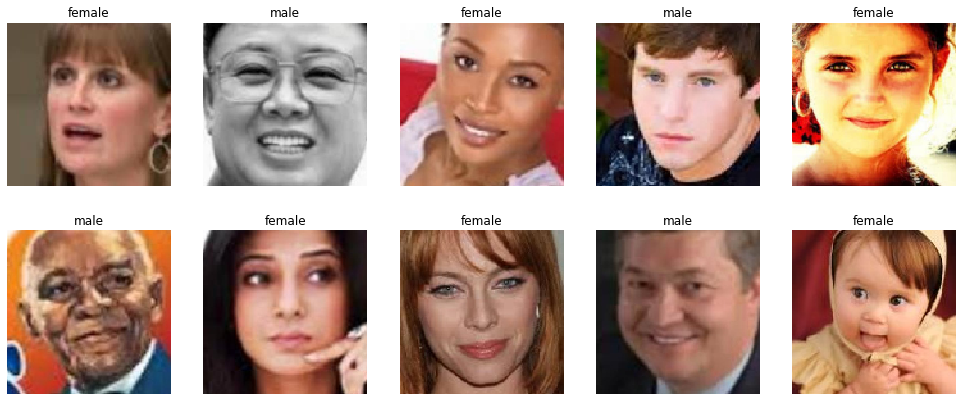

In [7]:
# Display some images
plt.figure(figsize=(17, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_ds[0][i], interpolation="nearest")
    plt.title(classes[train_ds[1][i]])
    plt.axis("off")

ANN

In [12]:
def get_classifier():
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    layer = layers.experimental.preprocessing.Rescaling(1. / 255)(input_layer)
    
    # VGG Model
    vgg_model = VGG16(input_tensor=layer, include_top=False, weights="imagenet")
    for layer in vgg_model.layers:
        layer.trainable = False
        
    layer = layers.Flatten()(vgg_model.output)
    layer = layers.Dense(512, activation="relu")(layer)
    layer = layers.Dense(128, activation="relu")(layer)
    layer = layers.Dense(32, activation="linear")(layer)
    layer = layers.Dense(1, activation="sigmoid")(layer)
    
    classifier = tf.keras.models.Model(inputs=input_layer, outputs=layer)
    
    classifier.compile(
        optimizer=tf.optimizers.Adam(learning_rate=1e-4),
        loss=tf.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )
    
    return classifier

with tpu_strategy.scope():
    classifier = get_classifier()

In [13]:
classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       1475

Training

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode="min", 
    monitor="val_loss", 
    patience=2,
    restore_best_weights=True
)

classifier_history = classifier.fit(
    train_ds[0],
    train_ds[1],
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    callbacks=early_stopping
)

Epoch 1/50
570/570 [==============================] - 24s 33ms/step - loss: 0.3744 - accuracy: 0.8309 - val_loss: 0.4237 - val_accuracy: 0.8136
Epoch 2/50
570/570 [==============================] - 10s 17ms/step - loss: 0.2952 - accuracy: 0.8721 - val_loss: 0.3185 - val_accuracy: 0.8658
Epoch 3/50
570/570 [==============================] - 10s 17ms/step - loss: 0.2619 - accuracy: 0.8897 - val_loss: 0.3112 - val_accuracy: 0.8667
Epoch 4/50
570/570 [==============================] - 10s 17ms/step - loss: 0.2289 - accuracy: 0.9047 - val_loss: 0.3141 - val_accuracy: 0.8720
Epoch 5/50
570/570 [==============================] - 10s 18ms/step - loss: 0.1919 - accuracy: 0.9255 - val_loss: 0.3576 - val_accuracy: 0.8570


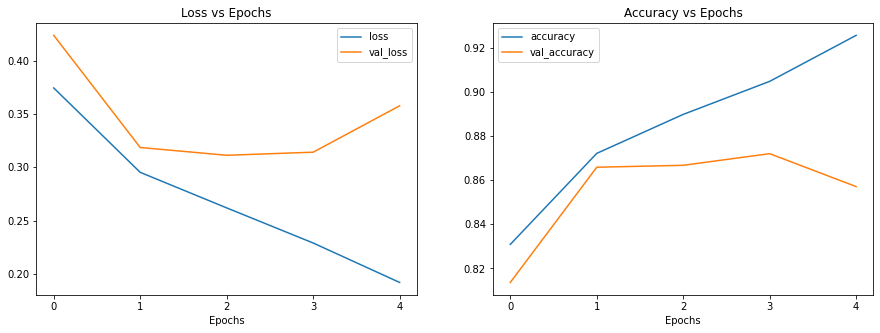

In [15]:
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(classifier_history.history.get("loss"))
plt.plot(classifier_history.history.get("val_loss"))
plt.xticks(range(len(classifier_history.history.get("loss"))))
plt.legend(["loss", "val_loss"])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")

# Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(classifier_history.history.get("accuracy"))
plt.plot(classifier_history.history.get("val_accuracy"))
plt.xticks(range(len(classifier_history.history.get("accuracy"))))
plt.legend(["accuracy", "val_accuracy"])
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")

plt.show()

Evaluation

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

y_true = valid_ds[1]
y_pred = classifier.predict(valid_ds[0]).ravel()

accuracy_list = []

# Thresholds
tpr, fpr, threshold = roc_curve(y_true, y_pred)

# Accuracy score based on different threshold
for thresh in threshold:
    thresh_y_pred = np.where(y_pred > thresh, 1, 0)
    accuracy_list.append((thresh, accuracy_score(y_true, thresh_y_pred)))
    
accuracy_list = pd.DataFrame(accuracy_list, columns=["threshold", "accuracy"], index=None)
accuracy_list.sort_values(by="accuracy", ascending=False, inplace=True)

# Thresholds with highest accuracy
best_threshold = accuracy_list.threshold.iloc[0]
accuracy_list.head()

,threshold,accuracy
483,0.500002,0.866477
585,0.367143,0.866257
584,0.371013,0.866257
482,0.502972,0.866257
494,0.489087,0.866257


In [17]:
print("Accuracy Score: 0.5 threshold")
print(accuracy_score(y_true, np.where(y_pred > 0.5, 1, 0)))

print(f"\nAccuracy Score: {best_threshold} threshold")
print(accuracy_score(y_true, np.where(y_pred > best_threshold, 1, 0)))

Accuracy Score: 0.5 threshold
0.866695900021925

Accuracy Score: 0.5000020861625671 threshold
0.8664766498574874


Predicting

In [18]:
import dlib
import requests

face_detecter = dlib.get_frontal_face_detector()
def detect_face(image: np.ndarray):
    expand = 30
    rects = face_detecter(image, 1)
    for i, rect in enumerate(rects[:1]):
        face_image = image[rect.top() - expand : rect.bottom() + expand, rect.left() - expand : rect.right() + expand]
        face_image = cv2.resize(face_image, (IMG_SIZE))
        return face_image
    return None

def get_random_google_images():
    # Unsplash urls
    urls = [
        "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1494790108377-be9c29b29330?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1557296387-5358ad7997bb?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=788&q=80",
        "https://images.unsplash.com/photo-1493106819501-66d381c466f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1577975819014-2d6f1e721e77?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1100&q=80",
        "https://images.unsplash.com/photo-1603775020644-eb8decd79994?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1509868918748-a554ad25f858?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1618716060974-98b20e2395cd?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=800&q=80",
        "https://images.unsplash.com/photo-1521227889351-bf6f5b2e4e37?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1250&q=80",
        "https://images.unsplash.com/photo-1611796154177-a10865bd9f62?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1585079225993-9f05a74f1d70?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1622109133861-5555bd667254?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=648&q=80",
        "https://images.unsplash.com/photo-1593757147298-e064ed1419e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492462543947-040389c4a66c?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80",
        "https://images.unsplash.com/photo-1506956191951-7a88da4435e5?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1334&q=80",
        "https://images.unsplash.com/photo-1523824921871-d6f1a15151f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1492106087820-71f1a00d2b11?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80",
        "https://images.unsplash.com/photo-1487222477894-8943e31ef7b2?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=852&q=80",
    ]
    images, face_images = [], []
    
    for url in urls:
        try:
            response = requests.get(url)
            
            if response.status_code == 200:
                # Downloading image
                image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
                # Detecting face using dlib
                face_img = detect_face(image)
                
                images.append(image)
                face_images.append(face_img)
        except Exception as error:
            print(error)
            continue
    return images, face_images

scraped_images, scraped_face_images = get_random_google_images()

print("Images Scraped:", len(scraped_images))

Images Scraped: 18


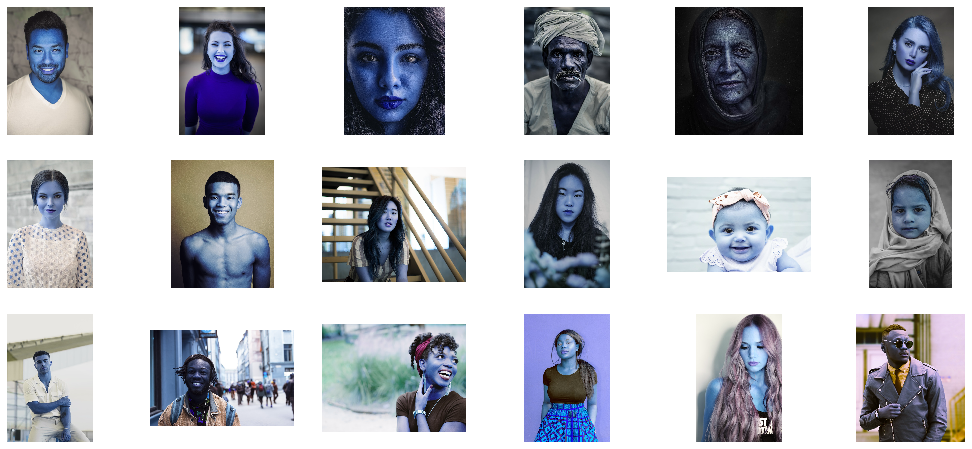

In [19]:
# Printing Scraped images
plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_images[i], interpolation="nearest")
    plt.axis("off")
plt.show()

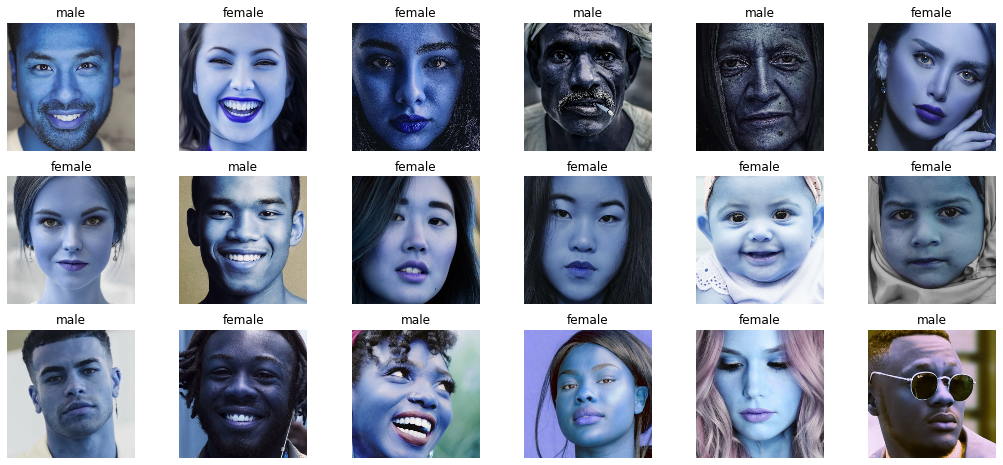

In [20]:
# Prediction on face images
classifier_prediction = classifier.predict(np.array(scraped_face_images))
classifier_prediction = np.where(classifier_prediction > best_threshold, 1, 0).ravel()

plt.figure(figsize=(18, 8))
for i in range(len(scraped_images)):
    plt.subplot(3, 6, i + 1)
    plt.imshow(scraped_face_images[i], interpolation="nearest")
    plt.axis("off")
    plt.title(classes[classifier_prediction[i]])
plt.show()